<h1> Exercises 2: More complex radar data!</h1>
In this notebook we have a few exercises and examples of code such that you can run it, play around with it to better understand how radar signal processing is performed in Python. 

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import processing.save_adc_data as sd
import processing._process_data as pd

<h5> 1. Beamforming </h5>

To help understand some of the ways to visualize radar data better, we have provided some processed data and some examples of Python plotting code to play around with. First we will go through the process of beamforming and show the bird eye view (BEV) heatmaps we can recover from this.
For beamforming, it requires knowing a few details about the antenna array that captured the data. We will describe it in more detail below.
For the rest of this section, the horizontal dimension will be defined as *x*, vertical as *z*, and depth will be defined by *y*. 

First, we load the data provided.


In [4]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/shanbhag/Documents/School/comm-proj-radars"

# loading data that is given
filename = r"BF_data1_taj_far"
data_dir = r"given_data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))
raw_data = mat_data['adcData']
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape
X = raw_data[:,num_z_stp//2,:,:,:]

Now we will describe the antenna array pattern. The data provided was taken by scanning a much smaller radar and set of antennas to emulate a larger antenna array. This is also known as SAR (Synthetic Aperture Radar), which you have seen in the pre-recorded lectures.

The scanning radar has 1 transmitter and 4 receivers, which are spaced $\lambda$/2 apart. This pattern is defined in the variable *rx_pos*. Then, we scan the radar horizontally and vertically. In this portion, only the horizontal scan is used, and we leave the implementation of recreating the 2D image for the evaluation.
The radar is moved along the x-axis 80 times, each time moving by a distance $\lambda$, which you can see is defined by the variable *x_pos*. Finally, *ant_pos* defines the total antenna scanning pattern. 

In [5]:
# define the antenna spacing
lm = 3e8/77e9 # define lambda for the antenna spacing
rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) / 2
x_pos = (np.reshape(np.arange(1,81,dtype=float),(-1,1)) * lm).T
ant_pos = np.reshape(rx_pos.T * x_pos.T ,(-1,1))


In some cases, there is a lot of self-interference between the antennas when we scan, and it appears as a very very strong signal very close to the radar. Thus, we sometimes will pass the raw signal through a highpass filter to get rid of the strong signals at the lower frequencies. You can try with and without this highpass filter and see how it affects the images. 

In [6]:
# just look at one vertical dimension since we are not using elevation
locs = ant_pos 
beat_freq = scipy.fft.fft(X, axis=-1)
beat_freq = np.reshape(beat_freq,(-1,adc_samples))

# define the azimuth angles (horizontal FOV) that we want to look at 
theta_s, theta_e = 0, 180

In [7]:
################# Change the values based on how much of the azimuth angles you want to see and the resolution ##################
# Define field of view in degrees that you want to process in theta 
def beamform_1d(beat_freq_data, theta_s, theta_e):
    # resolution of the angles
    theta_res = 1

    # Convert everything to Radians 
    theta_s_r = theta_s * (np.pi/180)
    theta_e_r = theta_e * (np.pi/180)
    theta_res*= (np.pi/180)
    theta_rad_lim = [theta_s_r,theta_e_r]

    # Generate arrays for theta 
    theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
    N_theta = len(theta)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

    print("Running this many iterations: %d " % (N_theta))

    ######################## BF Calculations ###########################3
    for kt in range(N_theta):
        sin_theta = np.sin(theta[kt]) # angle that the signal is coming from 
        Vec = np.exp(1j*(2*np.pi*(locs*sin_theta)/lm))
        VecRFI = np.squeeze(np.repeat(Vec[:, np.newaxis], adc_samples, axis=1))
        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(np.squeeze(beat_freq_data),VecRFI), axis=(0)))        
        print("Processed angle (%.2f)" % (theta[kt]*180/np.pi), end='\r')
    return sph_pwr, theta

Once we've performed beamforming on this 1D array, we can plot the corresponding images. In this example below, we have plotted the birds eye view for you. You can play around with the normalization to see how different thresholds impact the final image and what reflectors you can see. 

In [8]:
bf_output, theta = beamform_1d(beat_freq, theta_s,theta_e)

Running this many iterations: 180 


[70, 110]


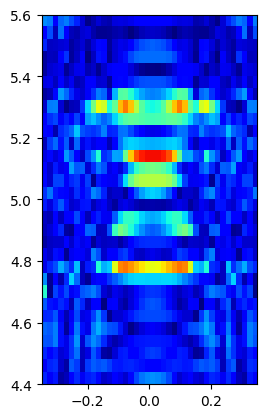

In [9]:
plot_lim_y = [110,140]
plot_lim_x = [70 - theta_s,110 - theta_s]
print(plot_lim_x)
to_plot = bf_output[plot_lim_x[0]:plot_lim_x[1],plot_lim_y[0]:plot_lim_y[1]]/np.max(np.reshape(bf_output,(1,-1)))
plt.imshow(abs((to_plot).T), extent=[theta[plot_lim_x[0]]-np.pi/2, theta[plot_lim_x[1]]-np.pi/2,plot_lim_y[0] * 0.04,plot_lim_y[1] * 0.04],cmap = 'jet',  vmin=0, vmax=0.05) # this is giving the y axis in meters, and x axis in angles 

<h5> 2. Matched Filter:</h5> 
Here we will compute the matched filter output for the captured data. We calculate the round trip distance of each point in x,y,z, and correlate it with the raw data. 


In [10]:
######## 1D Imaging in Cartesian #############
def matched_filter_1d(raw_data_1d, num_x_cells, num_y_cells):
    dlx = lm
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)


    MF_output = np.zeros((len(num_x_cells),len(num_y_cells)),dtype=complex)

    for i,cell_x in enumerate(num_x_cells):
        for j,cell_y in enumerate(num_y_cells):
                x_radar_tx = np.reshape(np.repeat(x_pos,4),(-1,1)) - 0.005 - 3 * lm / 2
                x_radar_rx = ant_pos
                

                cell_dist = np.sqrt((x_radar_tx - cell_x)**2 + (cell_y)**2) + np.sqrt((cell_x - x_radar_rx)**2 + (cell_y)**2)
                cell_dist = cell_dist + 0.15 # account for range bias
                temp_tau = (cell_dist)/c
                
                temp_sig_phase = 2.0*np.pi*fc_start*temp_tau
                total_phase = np.repeat(temp_sig_phase,adc_samples,axis=1) + 2.0 * np.pi * As_sci * (np.arange(0,adc_samples).T / adcSampleRate) * temp_tau
                temp_real = np.cos(total_phase)
                temp_imag = -np.sin(total_phase)
                MF_output[i,j] = MF_output[i,j] + np.sum((raw_data_1d *  (temp_real + temp_imag*1j)),axis=(0,1))
                            
                print("Processed cell (%.2f,%.2f)" % (cell_x,cell_y), end='\r')
    return MF_output 

In [11]:
X = np.squeeze(raw_data[:,num_z_stp//2,:,:,:]) # for matched filter we use the raw data directly!
X = np.reshape(X,(-1,adc_samples))
num_x_cells = np.arange(-0.4,0.6,0.02)
num_y_cells = np.arange(4,6,0.02)

MF_output = matched_filter_1d(X, num_x_cells, num_y_cells)

Now we will plot the heatmap computed below.

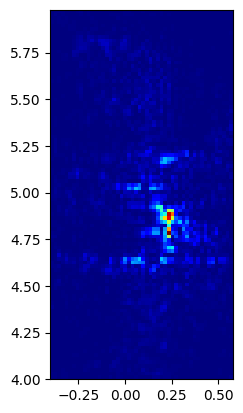

In [12]:
to_plot = (MF_output)**2
plt.imshow(abs(to_plot.T), extent=[num_x_cells[0], num_x_cells[-1], num_y_cells[0], num_y_cells[-1]],cmap = 'jet') # this is giving the y axis in meters, and x axis in angles 